In [ ]:
!pip install Keras-Preprocessing

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding,MaxPool1D
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
df = pd.read_csv("politik_cleaned.csv")
df.head()

,full_text,label,text_clean
0,Atalia Dituding Perpanjang Dinasti Politik kar...,0,atalia dituding perpanjang dinasti politik kar...
1,Tahun Baru. Saya harap ahli politik tanahair d...,1,tahun baru saya harap ahli politik tanahair da...
2,Saya cukup ghibah politik. Sudah diurus banyak...,1,saya cukup ghibah politik sudah diurus banyak ...
3,Buka X skrg udah kaya masuk kelas FISIP ajg is...,1,buka x skrg udah kaya masuk kelas fisip ajg is...
4,Saya menjual NASIHAT UNTUK SBY ~ politik ~ huk...,1,saya menjual nasihat untuk sby politik hukum p...


In [ ]:
df = df[["text_clean", "label"]]
df.rename(columns={"text_clean": "text", "label": "label"}, inplace=True)
# df.rename(columns={"Tweets": "text", "Label": "label"}, inplace=True)
# df["label"] = df["label"].map({"Hoax": 1, "Valid": 0})
df['label'] = df['label'].astype('int')
df.replace("", float("NaN"), inplace=True)
df.dropna(inplace=True)

df = df[['text', 'label']]

df.sample(5)

,text,label
1449,gue mau tobat ngomongin politik tapi anjing in...,1
2920,yang dibilang prof tnh waktu di malang pendidi...,1
3399,ketua pembangkang dlm entiti zionis lapid kera...,1
845,gue cuma pengen ts ga ada afiliasi sama piliha...,1
3791,masih kepikiran si podcaster politik itu pake ...,1


In [ ]:
df.shape

(4263, 2)

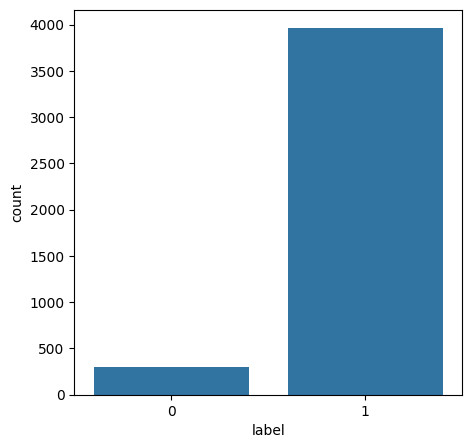

In [ ]:
plt.figure(figsize=(5, 5))
ax = sns.countplot(x=df['label'])


# W2V


In [ ]:
from gensim.models import Word2Vec

In [ ]:
tokenized_tweet = df['text'].apply(lambda x: x.split())
tokenized_tweet

,text
0,"[atalia, dituding, perpanjang, dinasti, politi..."
1,"[tahun, baru, saya, harap, ahli, politik, tana..."
2,"[saya, cukup, ghibah, politik, sudah, diurus, ..."
3,"[buka, x, skrg, udah, kaya, masuk, kelas, fisi..."
4,"[saya, menjual, nasihat, untuk, sby, politik, ..."
...,...
4258,"[menteri, itu, jabatan, politik, meskipun, beg..."
4259,"[jeje, govinda, tak, kapok, terjun, ke, politi..."
4260,"[jauhi, jangan, layan, kelompok, anutan, narsi..."
4261,"[sebenarnya, kejadian, saat, ini, tuh, momentu..."


In [ ]:
#setting parameter word2vec
model = Word2Vec(sentences=tokenized_tweet, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [ ]:
model = Word2Vec.load("word2vec.model")
model.train(tokenized_tweet, total_examples=len(tokenized_tweet), epochs=10)

(936914, 1071370)

In [ ]:
from gensim.models import KeyedVectors

word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")

wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
vector = wv['gagal']

vector

array([-0.20738249,  0.4766761 ,  0.20082858, -0.02361227, -0.1121914 ,
       -0.6723571 ,  0.26583645,  0.7254755 , -0.35820818, -0.7945284 ,
       -0.14494891, -0.6677502 ,  0.05450572,  0.27698892,  0.33833575,
       -0.3186444 ,  0.36383852, -0.3178738 , -0.09431215, -0.77591455,
        0.04861698,  0.18406518,  0.13366415, -0.17963973, -0.23109794,
        0.12747893, -0.31410563, -0.34120923, -0.34467328,  0.16611163,
        0.26464933, -0.2620271 ,  0.09813722, -0.2372226 , -0.3639228 ,
        0.5631425 ,  0.16578278, -0.23139192, -0.22519605, -0.6590535 ,
        0.2953216 , -0.25682414, -0.15077415,  0.20251115,  0.13973148,
       -0.13220772, -0.506063  , -0.09543248,  0.33555382,  0.15819667,
       -0.04978228, -0.5463877 ,  0.01326995, -0.16200586, -0.3692019 ,
        0.31473428,  0.4142818 ,  0.21444665, -0.16428412,  0.03765683,
        0.22811303,  0.09398697, -0.12347979,  0.02404004, -0.25905812,
        0.4988537 , -0.10331614,  0.37524298, -0.69708693,  0.44

In [ ]:
X = df['text']
y = df['label']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [ ]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break

politik -> 1
gue -> 2
dan -> 3
di -> 4
yg -> 5
yang -> 6
ini -> 7
itu -> 8
ada -> 9
indonesia -> 10


In [ ]:
maxlen = 700

X = pad_sequences(X, maxlen=maxlen)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [ ]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        if word in model:  # Check if the word is in the model
            weight_matrix[i] = model[word]
    return weight_matrix

In [ ]:
embedding_vectors = get_weight_matrix(wv, word_index)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
#LSTM
kf = KFold(n_splits=10)

reports = []
confusions = []

for train_index, test_index in kf.split(X):

  X_train = X[train_index]
  y_train = y[train_index]

  X_test = X[test_index]
  y_test = y[test_index]

  model = Sequential()
  model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], input_length=maxlen, trainable=False))
  #LSTM
  model.add(LSTM(units=128))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

  model.summary()
  model.fit(X_train, y_train, validation_split=0.3, epochs=6)

  y_pred = (model.predict(X_test) >= 0.5).astype("int")

  accuracy_score(y_test, y_pred)

  reports.append(classification_report(y_test, y_pred))
  confusions.append(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_30 (Embedding)             │ ?                           │       1,580,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,580,600 (6.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,580,600 (6.03 MB)

Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - acc: 0.8858 - loss: 0.2791 - val_acc: 0.8844 - val_loss: 0.3142
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - acc: 0.9391 - loss: 0.1727 - val_acc: 0.8836 - val_loss: 0.3767
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - acc: 0.9480 - loss: 0.1750 - val_acc: 0.8836 - val_loss: 0.2833
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9465 - loss: 0.1653 - val_acc: 0.8853 - val_loss: 0.2626
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - acc: 0.9554 - loss: 0.1414 - val_acc: 0.8836 - val_loss: 0.3023
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.9494 - loss: 0.1422 - val_acc: 0.8827 - val_loss: 0.3129
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)             │ ?                           │       1,580,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,580,600 (6.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,580,600 (6.03 MB)

Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - acc: 0.8927 - loss: 0.2710 - val_acc: 0.8836 - val_loss: 0.3231
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - acc: 0.9426 - loss: 0.1854 - val_acc: 0.8827 - val_loss: 0.2639
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9420 - loss: 0.1771 - val_acc: 0.8862 - val_loss: 0.2795
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9440 - loss: 0.1574 - val_acc: 0.8836 - val_loss: 0.2820
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - acc: 0.9481 - loss: 0.1657 - val_acc: 0.8836 - val_loss: 0.2856
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - acc: 0.9470 - loss: 0.1745 - val_acc: 0.8905 - val_loss: 0.2632
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)             │ ?                           │       1,580,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,580,600 (6.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,580,600 (6.03 MB)

Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - acc: 0.9180 - loss: 0.2571 - val_acc: 0.8836 - val_loss: 0.2878
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9426 - loss: 0.1674 - val_acc: 0.8836 - val_loss: 0.3083
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - acc: 0.9534 - loss: 0.1617 - val_acc: 0.8949 - val_loss: 0.2520
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.9508 - loss: 0.1541 - val_acc: 0.8836 - val_loss: 0.2732
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.9422 - loss: 0.1696 - val_acc: 0.8836 - val_loss: 0.3008
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - acc: 0.9427 - loss: 0.1681 - val_acc: 0.8853 - val_loss: 0.2741
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_33 (Embedding)             │ ?                           │       1,580,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,580,600 (6.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,580,600 (6.03 MB)

Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - acc: 0.8993 - loss: 0.2505 - val_acc: 0.8837 - val_loss: 0.2841
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - acc: 0.9422 - loss: 0.1753 - val_acc: 0.8837 - val_loss: 0.3073
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - acc: 0.9483 - loss: 0.1599 - val_acc: 0.8845 - val_loss: 0.3017
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.9430 - loss: 0.1742 - val_acc: 0.8837 - val_loss: 0.3151
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9429 - loss: 0.1679 - val_acc: 0.8863 - val_loss: 0.2653
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - acc: 0.9478 - loss: 0.1518 - val_acc: 0.8837 - val_loss: 0.2903
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)             │ ?                           │       1,580,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,580,600 (6.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,580,600 (6.03 MB)

Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - acc: 0.9492 - loss: 0.2132 - val_acc: 0.8845 - val_loss: 0.3355
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - acc: 0.9613 - loss: 0.1300 - val_acc: 0.8837 - val_loss: 0.2874
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - acc: 0.9612 - loss: 0.1349 - val_acc: 0.8837 - val_loss: 0.3437
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9633 - loss: 0.1299 - val_acc: 0.8819 - val_loss: 0.2895
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - acc: 0.9609 - loss: 0.1261 - val_acc: 0.8854 - val_loss: 0.3322
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - acc: 0.9624 - loss: 0.1168 - val_acc: 0.8828 - val_loss: 0.2959
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_35 (Embedding)             │ ?                           │       1,580,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,580,600 (6.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,580,600 (6.03 MB)

Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - acc: 0.9528 - loss: 0.1807 - val_acc: 0.8837 - val_loss: 0.3059
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9629 - loss: 0.1359 - val_acc: 0.8837 - val_loss: 0.3018
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - acc: 0.9653 - loss: 0.1308 - val_acc: 0.8837 - val_loss: 0.2864
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - acc: 0.9665 - loss: 0.1202 - val_acc: 0.8837 - val_loss: 0.3032
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.9631 - loss: 0.1302 - val_acc: 0.8837 - val_loss: 0.2953
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9704 - loss: 0.1126 - val_acc: 0.8837 - val_loss: 0.3001
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_36 (Embedding)             │ ?                           │       1,580,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_36 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,580,600 (6.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,580,600 (6.03 MB)

Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - acc: 0.9531 - loss: 0.2177 - val_acc: 0.8837 - val_loss: 0.2987
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - acc: 0.9502 - loss: 0.1580 - val_acc: 0.8837 - val_loss: 0.2900
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - acc: 0.9500 - loss: 0.1602 - val_acc: 0.8837 - val_loss: 0.2905
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - acc: 0.9579 - loss: 0.1393 - val_acc: 0.8837 - val_loss: 0.2813
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - acc: 0.9515 - loss: 0.1638 - val_acc: 0.8880 - val_loss: 0.2631
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - acc: 0.9437 - loss: 0.1566 - val_acc: 0.8837 - val_loss: 0.3149
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_37 (Embedding)             │ ?                           │       1,580,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_37 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,580,600 (6.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,580,600 (6.03 MB)

Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - acc: 0.9131 - loss: 0.2335 - val_acc: 0.8932 - val_loss: 0.3036
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - acc: 0.9507 - loss: 0.1567 - val_acc: 0.8932 - val_loss: 0.3847
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9491 - loss: 0.1667 - val_acc: 0.8941 - val_loss: 0.2641
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - acc: 0.9539 - loss: 0.1485 - val_acc: 0.8924 - val_loss: 0.2716
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - acc: 0.9537 - loss: 0.1530 - val_acc: 0.8950 - val_loss: 0.2795
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - acc: 0.9560 - loss: 0.1464 - val_acc: 0.8941 - val_loss: 0.3009
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_38 (Embedding)             │ ?                           │       1,580,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_38 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,580,600 (6.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,580,600 (6.03 MB)

Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - acc: 0.9417 - loss: 0.2240 - val_acc: 0.9115 - val_loss: 0.2470
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - acc: 0.9483 - loss: 0.1632 - val_acc: 0.9089 - val_loss: 0.2209
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - acc: 0.9506 - loss: 0.1608 - val_acc: 0.9167 - val_loss: 0.2269
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9538 - loss: 0.1550 - val_acc: 0.9106 - val_loss: 0.2503
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - acc: 0.9507 - loss: 0.1475 - val_acc: 0.9115 - val_loss: 0.2218
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - acc: 0.9553 - loss: 0.1441 - val_acc: 0.9115 - val_loss: 0.2482
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_39 (Embedding)             │ ?                           │       1,580,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_39 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,580,600 (6.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,580,600 (6.03 MB)

Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - acc: 0.8936 - loss: 0.2528 - val_acc: 0.9106 - val_loss: 0.2449
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - acc: 0.9449 - loss: 0.1607 - val_acc: 0.9106 - val_loss: 0.2559
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9414 - loss: 0.1718 - val_acc: 0.9106 - val_loss: 0.2641
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - acc: 0.9567 - loss: 0.1429 - val_acc: 0.9132 - val_loss: 0.2540
Epoch 5/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.9552 - loss: 0.1521 - val_acc: 0.9115 - val_loss: 0.2317
Epoch 6/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - acc: 0.9576 - loss: 0.1344 - val_acc: 0.9106 - val_loss: 0.2237
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=1, batch_size=32)  # Adjust epochs and batch size as needed

120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9397 - loss: 0.1766


In [ ]:
model.summary()

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_39 (Embedding)             │ (None, 700, 100)            │       1,580,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_39 (LSTM)                       │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,932,733 (7.37 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 1,580,600 (6.03 MB)

 Optimizer params: 234,756 (917.02 KB)

In [ ]:
#hasil
for i in range (len(reports)):
  print(f"==========================={i+1}=============================")
  print("REPORT:")
  print(reports[i])

===========================1=============================
REPORT:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.97      1.00      0.99       416

    accuracy                           0.97       427
   macro avg       0.49      0.50      0.49       427
weighted avg       0.95      0.97      0.96       427

===========================2=============================
REPORT:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.99      1.00      1.00       424

    accuracy                           0.99       427
   macro avg       0.50      0.50      0.50       427
weighted avg       0.99      0.99      0.99       427

===========================3=============================
REPORT:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.98      1.00      

In [ ]:
def report(matrix):
  TP = matrix[1][1]
  TN = matrix[0][0]
  FP = matrix[1][0]
  FN = matrix[0][1]

  accuracy = (TP+TN)/(TP+FP+FN+TN)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  errorRate = (FP+FN)/(TP+FP+FN+TN)
  f1 = 2*TP / (2*TP + FP + FN)

  print(f"Accuracy = {accuracy}")
  print(f"Precision = {precision}")
  print(f"Recall = {recall}")
  print(f"Error Rate = {errorRate}")
  print(f"f1-score = {f1}")

In [ ]:
result = [[ 0,   0],[  0, 0],]

for i in range (len(confusions)):
  result = result + confusions[i]


In [ ]:
print(f"Overall Performance")
report(result)

Overall Performance
Accuracy = 0.9303307529908516
Precision = 0.9984859954579863
Recall = 0.931497175141243
Error Rate = 0.06966924700914849
f1-score = 0.9638290098648155
